# <div style="text-align: center">Neural Networks - Kohn-Sham Mapping</div> 
 
## <div style="text-align: center">Jon Vandermause, Steven Torrisi, Simon Batzner</div> 

## <div style="text-align: center">Gaussian Potential-to-Energy </div> 

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os

import numpy as np
import matplotlib.pyplot as plt
import argparse

from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense
from sklearn.metrics import mean_squared_error
from keras import optimizers
from keras.callbacks import TensorBoard, EarlyStopping
from sklearn.model_selection import train_test_split
from math import sqrt
from KRR_reproduce import *

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Using TensorFlow backend.


## Parameters

In [2]:
SEED = 42
ev2kcal = 1/0.043       # conversion factor
EPOCHS = 50000          # maximum number of training epochs
OPTIMIZER = 'sgd'       # sgd or adam
LEARNING_RATE = 0.01    # larger means faster learning, more aggressive
GRID_SPACE = 0.6        # instead of 0.08 in the paper -- makes it faster and the input dim much smaller
DECAY = 0.0             # decay learning rate as training advances
SIM_NO = 150            # total number of data points
M = 140                 # number of training points

HIDDEN = (50,)
    
# path to data
os.environ['PROJDIR'] = '/Users/simonbatzner1/Desktop/Research/Research_Code/ML-electron-density'
STR_PREF = os.environ['PROJDIR'] + '/data/H2_DFT/temp_data/store/'

# ignore tf warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## Load data

In [3]:
ens = []
seps = []
fours = []

for n in range(SIM_NO):
    
    # load separation, energy, and density
    sep = np.load(STR_PREF + 'sep_store/sep' + str(n) + '.npy')
    en = np.load(STR_PREF + 'en_store/en' + str(n) + '.npy')
    four = np.load(STR_PREF + 'four_store/four' + str(n) + '.npy')

    # put results in a nicer format
    sep = np.reshape(sep, (1,))[0]
    en = np.reshape(en, (1,))[0]['energy']
    four = np.real(four)

    # store quantities
    ens.append(en)
    seps.append(sep)
    fours.append(four)

## Network functions

In [4]:
def init_architecture(input_shape, hidden_size, summary, activation='relu'):
    """
    Built Neural Network using Keras

    :param input_shape: shape of the input data
    :param hidden_size: tuple of number of hidden layers, eg. (30, 30, 40) builds a network with hidden layers 30-30-40
    :param summary: boolean, true plots a summary
    :param activation: activiation function
    :return: keras Sequential model
    """
    model = Sequential()
    print(input_shape)

    # hidden layers
    model.add(Dense(hidden_size[0], input_shape=input_shape, activation=activation))
    for layer_size in hidden_size[1:]:
        model.add(Dense(layer_size, activation=activation))
        model.add(Dropout(0.2))

    # output layer
    model.add(Dense(1, activation='linear'))

    if summary:
        model.summary()

    return model

In [5]:
def train(model, training_data, training_labels, validation_data, validation_labels, batchsize=64):
    """"
    Train Neural Network model
    """
    history = model.fit(training_data, training_labels, validation_data=(validation_data, validation_labels),
                        batch_size=batchsize,
                        verbose=0, shuffle=True)
    return history

## Create Gaussian Potentials

In [6]:
pots = []
grid_len = 5.29177 * 2

for n in range(SIM_NO):
    dist = seps[n]
    pot = pot_rep(dist, grid_len, grid_space=GRID_SPACE)
    pot = pot.flatten()
    pots.append(pot)

## Setup training and test data

In [7]:
data = pots
labels = ens

# define training and test indices
train_indices = [int(n) for n in np.round(np.linspace(0,149,M))]
test_indices = [n for n in range(150) if n not in train_indices]

if len(train_indices) != M: 
    print("Size of training set doesn't match the M specified")
    
x_train = np.array([data[n] for n in train_indices])
x_test = np.array([data[n] for n in test_indices])
y_test_seps = np.array([seps[n] for n in test_indices])
y_train = np.array([labels[n] for n in train_indices])
y_test =np.array([labels[n] for n in test_indices])

# convert to np arrays
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

print(x_train.shape)
print(y_test.shape)

(140, 5832)
(10,)


## Build model and train

In [8]:
# build neural net
model = init_architecture(input_shape=pots[0].shape, hidden_size=tuple(HIDDEN), summary=True,
                          activation='tanh')

# set optimizer and compile
adam = optimizers.Adam(lr=LEARNING_RATE, decay=DECAY)
sgd = optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)

if OPTIMIZER == 'adam': 
    model.compile(optimizer=adam, loss='mean_squared_error', metrics=['mse'])
elif OPTIMIZER == 'sgd': 
    model.compile(optimizer=sgd, loss='mean_squared_error', metrics=['mse'])
else: 
    "Default optimizer ADAM being used..."
    model.compile(optimizer=adam, loss='mean_squared_error', metrics=['mse'])
    
# early stopping on validation error
es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=500,
                   verbose=10, mode='auto')

# log graph and gradients
tb = TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=1, write_graph=True, write_grads=True,
                 write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)

# save training history
history = model.fit(x_train, y_train, epochs=EPOCHS, verbose=0, validation_split=0.2, callbacks=[es, tb])

(5832,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                291650    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 291,701
Trainable params: 291,701
Non-trainable params: 0
_________________________________________________________________
Epoch 00565: early stopping


## Results

In [9]:
from sklearn.metrics import mean_absolute_error
# Predict
test_loss = model.evaluate(x_test, y_test)

# Eval on training data
y_true, y_pred = y_train, model.predict(x_train)
print("\nMAE on training data [kcal/mol]: \t{}".format(mean_absolute_error(y_true, y_pred)*ev2kcal))

# Eval on test data
y_true, y_pred = y_test, model.predict(x_test)
print("MAe on test data [kcal/mol]: \t\t{}".format(mean_absolute_error(y_true, y_pred)*ev2kcal))

10/10 [==============================] - 0s 491us/step

MAE on training data [kcal/mol]: 	3.2740315595204397
MAe on test data [kcal/mol]: 		2.8463858537665456



  	Pred 	| 	True

[[-30.63335419 -30.57717032]
 [-31.24387741 -31.51679575]
 [-31.59539032 -31.74695245]
 [-31.63101196 -31.60985192]
 [-31.3663559  -31.28161023]
 [-30.88724136 -30.85878473]
 [-30.32676697 -30.39669482]
 [-29.82733917 -29.92710748]
 [-29.5054245  -29.46878253]
 [-29.43473816 -29.03215704]]


Test Loss: 0.02873084880411625
dict_keys(['val_mean_squared_error', 'mean_squared_error', 'val_loss', 'loss'])


Text(0.5,1,'model loss')

Text(0,0.5,'loss')

Text(0.5,0,'epoch')

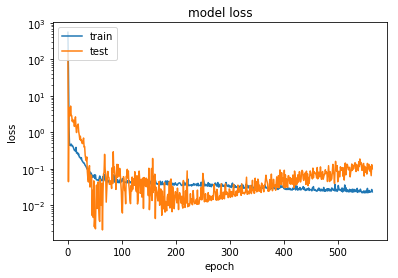

In [10]:
# Predict on new data
print("\n  \tPred \t| \tTrue\n")
print(np.c_[y_pred, y_true])

# Results
print("\n\nTest Loss: {}".format(test_loss[1]))

# Plot loss history
print(history.history.keys())
plt.semilogy(history.history['loss']);
plt.semilogy(history.history['val_loss']);
plt.title('model loss');
plt.ylabel('loss');
plt.xlabel('epoch');
plt.legend(['train', 'test'], loc='upper left');
plt.show()

Text(0.5,0,'Distance [Angstrom]')

Text(0,0.5,'Energy [eV]')

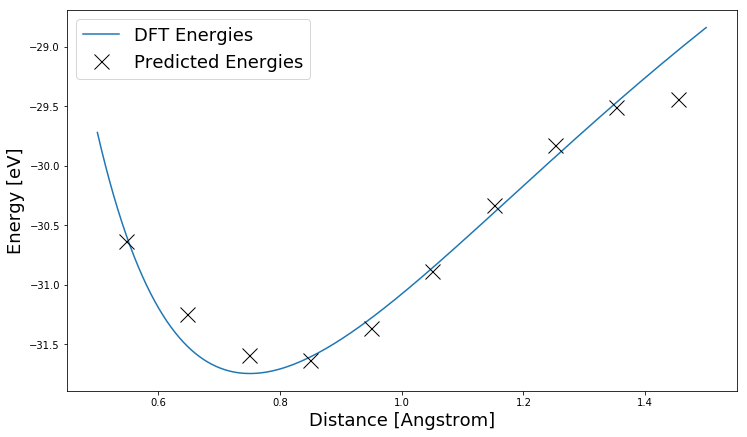

In [11]:
fig = plt.figure(figsize=(12, 7)) 
plt.plot(seps, ens, label = 'DFT Energies');
plt.plot(y_test_seps, y_pred, 'kx', MarkerSize = 15, mew = 1, label = 'Predicted Energies'); 
plt.legend(fontsize = 18);
plt.xlabel('Distance [Angstrom]', fontsize = 18);
plt.ylabel('Energy [eV]', fontsize = 18);
plt.show()

For comparison, from [1]: "The MAE that is introduced by the PBE approximation on the H2 data set is 2.3 kcal/mol (compared to exact CI calculations)"" 

[1] Brockherde et al. Bypassing the Kohn-Sham equations with machine learning. Nature Communications 8, 872 (2017)